## Work
1. 試比較 save_best_only 與否的差異
2. 請僅存入將 save_weights_only 設定為 True, 並嘗試 reset ipynb 並將模型與權重重新建回並預測 x_test

In [0]:
import os
import keras

# Disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [0]:
train, test = keras.datasets.cifar10.load_data()

In [0]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [0]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [2]:
from keras.layers import Input,Dense,BatchNormalization
from keras.models import Model

def build_mlp(input_shape, output_units=10, num_neurons=[512,256,128]):
    """Code Here
    建立你的神經網路
    """
    input_layer = Input(input_shape)
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = Dense(units=n_units, activation='relu', name='hidden_layer'+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = Dense(units=n_units, activation='relu', name='hidden_layer'+str(i+1))(x)
            x = BatchNormalization()(x)
    
    output = Dense(units=output_units, activation='softmax', name='output')(x)
    model = Model(inputs=[input_layer], outputs=[output])

    return model

Using TensorFlow backend.


In [0]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [0]:
?ModelCheckpoint()

In [31]:
# 載入 Callbacks
"""Code Here
設定 callbacks: model checkpoint
"""

from keras.callbacks import ModelCheckpoint, EarlyStopping
earlystop = EarlyStopping(monitor='val_acc',
                          patience=5,
                          verbose=1)

model_ck_bO_True = ModelCheckpoint(filepath='./tmp2.h5',
                           monitor='val_acc',
                           save_weights_only =True)

model_ck_bO_False = ModelCheckpoint(filepath='./tmp3.h5',
                           monitor='val_acc')


models_ck = [model_ck_bO_True, model_ck_bO_False]
models_name = ['weights_only : True', 'weights_only : False']

results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""

for i, ck in enumerate(models_ck):
    model = build_mlp(x_train.shape[1:])
    opt = keras.optimizers.SGD(lr=LEARNING_RATE, momentum=MOMENTUM, nesterov=True)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs= EPOCHS,
              validation_data=(x_test,y_test),
              shuffle=True, verbose=0,
              callbacks=[earlystop,ck])
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    results[models_name[i]] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


Epoch 00032: early stopping
Epoch 00028: early stopping


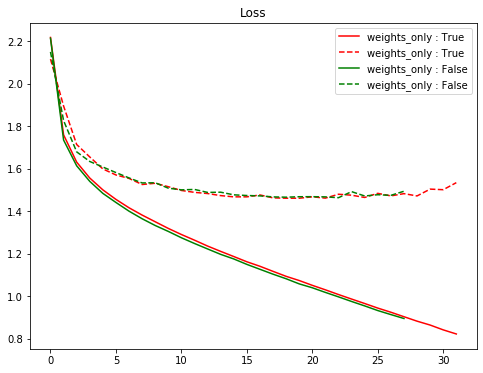

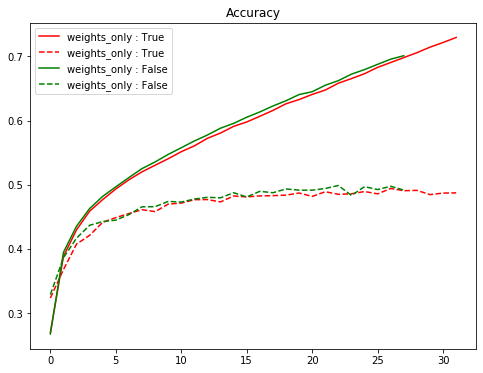

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
# plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

In [17]:
model = keras.models.load_model("./tmp0.h5") # save_best_only:True
loss_loadback, acc_loadback = model.evaluate(x_test, y_test)
loss_loadback, acc_loadback

10000/10000 [==============================] - 1s 117us/step


(1.4740331689834594, 0.4862)

In [16]:
model = keras.models.load_model("./tmp1.h5") # save_best_only:False
loss_loadback, acc_loadback = model.evaluate(x_test, y_test)
loss_loadback, acc_loadback

10000/10000 [==============================] - 1s 118us/step


(1.4846464986801147, 0.4883)

In [21]:
model = build_mlp(x_train.shape[1:])
model.load_weights("./tmp2.h5") # save_weight_only:True

opt = keras.optimizers.SGD(lr=LEARNING_RATE, momentum=MOMENTUM, nesterov=True)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

score = model.evaluate(x_test, y_test)
score[0], score[1]

10000/10000 [==============================] - 2s 168us/step


(1.5351541244506837, 0.4873)